In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import pickle
from sklearn.feature_selection import f_regression, SelectKBest
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter
from scipy.stats import normaltest
import matplotlib.ticker as ticker
import statsmodels.formula.api as smf


## DATA

In [2]:
rawdata = pd.read_csv('for_model.csv')
df=rawdata.copy()

In [3]:
# 為了圖表可以顯示中文的設定
# 設置字體為微軟雅黑
plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['axes.unicode_minus'] = False 



In [4]:
df.columns

Index(['movie_id', 'imdb_id', 'title', 'en_title', 'budget', 'revenue',
       'release_date', 'avg_rating', 'vote_count', 'casts', 'genres',
       'production_companies', 'adult', 'budget_transfer', 'revenue_transfer',
       'actor1', 'actor2', 'actor3', 'actor4', 'actor5', 'actor6', 'year',
       'actor1_count', 'actor2_count', 'actor3_count', 'actor4_count',
       'actor5_count', 'actor6_count', 'sequal', 'year_gap', 'reunion_holiday',
       'non_reunion_holiday', 'decade', 'award_num', 'company_num',
       'genres_num', 'director', 'directing_win_count',
       'production_companies_freq', 'genres_freq', 'director_freq',
       'release_weekday', 'release_month'],
      dtype='object')

In [5]:
# 稍微看一下各個重要變數統計量
df['revenue'].describe()


count    9.404000e+03
mean     6.500059e+07
std      1.553383e+08
min      1.000000e+00
25%      9.379888e+05
50%      1.100000e+07
75%      5.699723e+07
max      2.920357e+09
Name: revenue, dtype: float64

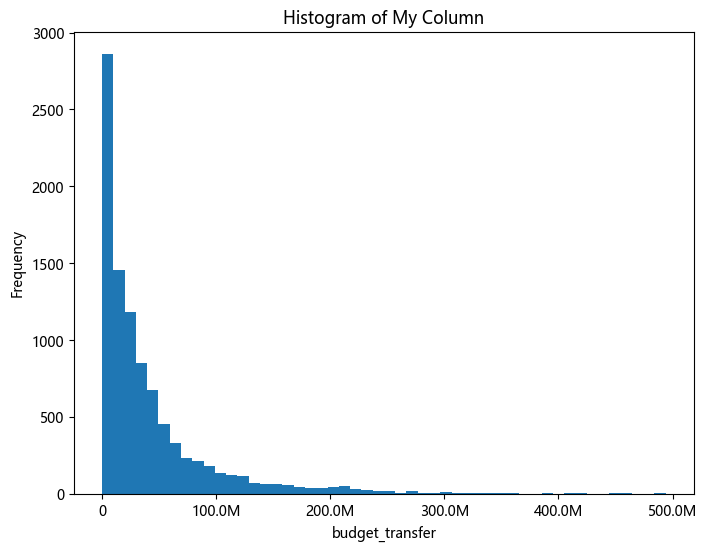

In [6]:
# 檢查是否符合常態分布 預算跟票房皆符合 但圖不像，還是右偏型態
def plot_histogram(column):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.hist(column, bins=50)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.1f}M'.format(x/1e6) if x >= 1e6 else int(x)))
    plt.title('Histogram of My Column')
    plt.xlabel('budget_transfer')
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(df['budget_transfer'])

In [7]:
# 使用 normaltest() 函數檢驗該欄位是否符合常態分佈
stat, p = normaltest(df['budget_transfer'])
if p < 0.05:
    print('不符合常態')
else:
    print('是常態')


是常態


### 資料篩選與轉換  (依實際需求及測試調整)

In [8]:
# 資料只取2010年後 ，以前電影離群過大 ，加上分析過久年代的電影無意義
dfyear=df[df['year']>2010]

In [9]:
# 預算與收入打平的資料剔除
dfyear=dfyear[dfyear['budget']!=dfyear['revenue']]


In [10]:
# 重新頻率編碼，因有再做其他篩選
freq=dfyear['production_companies'].value_counts(normalize=True)
dfyear['production_companies_freq'] = dfyear['production_companies'].map(freq)
freq1=dfyear['genres'].value_counts(normalize=True)
dfyear['genres_freq'] =dfyear['genres'].map(freq1)

In [11]:
# LOG轉換
dfyear['budget_transfer'] = np.log(dfyear['budget_transfer'])
dfyear['revenue_transfer'] = np.log(dfyear['revenue_transfer'])

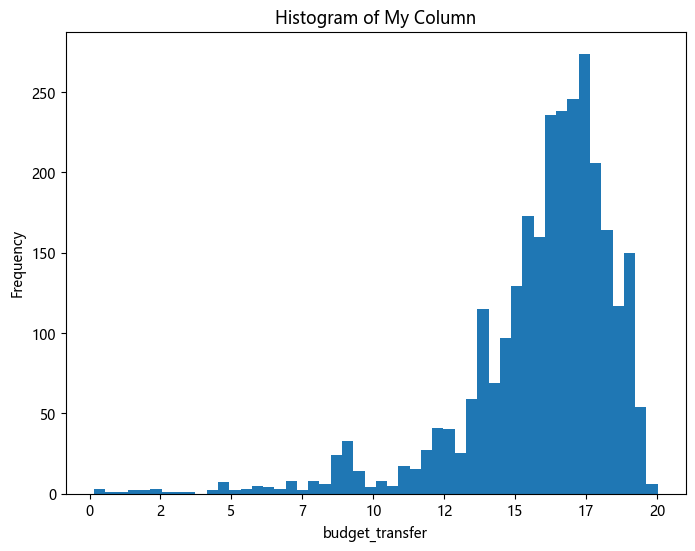

In [12]:
# 有做LOG轉換的話檢查分布變化
plot_histogram(dfyear['budget_transfer'])

In [100]:
X = dfyear[['budget','actor1_count','actor2_count','actor3_count','actor4_count','actor5_count','actor6_count','sequal','year_gap','reunion_holiday','non_reunion_holiday','decade','award_num','company_num','genres_num','directing_win_count','production_companies_freq','genres_freq','director_freq','release_weekday','release_month']]
y = dfyear['revenue']

## 多模型比較

LinearRegression R2 score: 0.610216802054266
XGBoost R2 score: 0.6047290417403197
SVM R2 score: 0.5367725095481638
DecisionTree R2 score: 0.306994683199855


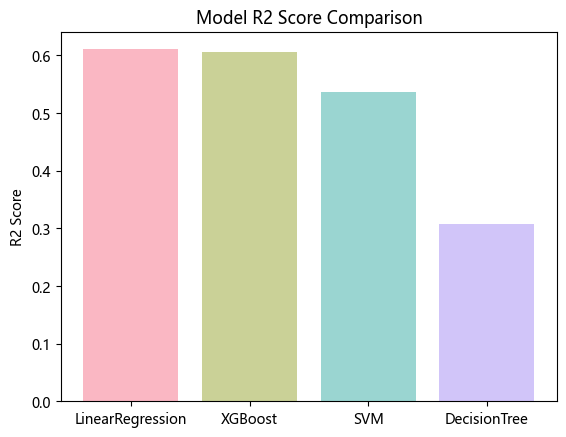

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import xgboost as xgb

def train_and_evaluate_models(X, y, random_state=48, scaler=StandardScaler()):
    # 將數據拆分為訓練集和測試集
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

    # 標準化數據
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # 視需求標準化y
    #y_scaler = StandardScaler()  # 創建一個單獨的標準化器用於 y
    #y_train = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1)).ravel()
    #y_test = y_scaler.transform(np.array(y_test).reshape(-1, 1)).ravel()

    # 定義模型
    models = {
        'LinearRegression': LinearRegression(),
        'XGBoost': xgb.XGBRegressor(max_depth=8, n_estimators=2000, learning_rate=0.008),
        'SVM': SVR(),
        'DecisionTree': DecisionTreeRegressor()
    }

    # 訓練模型，進行預測並使用 R2 分數進行評估
    r2_scores = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        r2_scores[model_name] = r2_score(y_test, preds)
        print(f'{model_name} R2 分數：{r2_scores[model_name]}')

    # 為每個模型生成顏色
    colors = sns.color_palette("husl", len(models))

    # 使用條形圖可視化 R2 分數
    fig, ax = plt.subplots()
    model_names = list(r2_scores.keys())
    r2_values = list(r2_scores.values())
    y_pos = np.arange(len(model_names))
    ax.bar(y_pos, r2_values, align='center', alpha=0.5, color=colors)
    ax.set_xticks(y_pos)
    ax.set_xticklabels(model_names)
    ax.set_ylabel('R2')
    ax.set_title('模型比較')
    plt.show()

train_and_evaluate_models(X, y, random_state=3)


## 挑選特徵

### 隨機森林

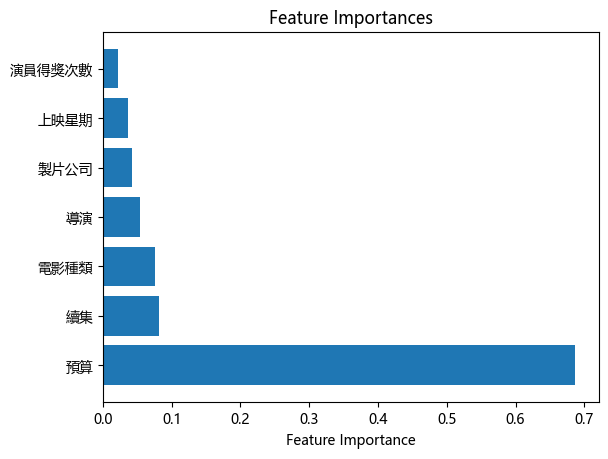

,budget,sequal,genres_freq,production_companies_freq,award_num,director_freq,release_weekday
3,100,0.0,0.001063,0.000106,0.0,0.000106,2.0
6,70,0.0,0.000106,0.000106,0.0,0.000213,1.0
8,5000,0.0,0.007444,0.000106,0.0,0.000106,5.0
9,10000,0.0,0.000106,0.000106,1.0,0.000213,6.0
10,900,0.0,0.001063,0.000106,0.0,0.000106,5.0
...,...,...,...,...,...,...,...
9399,175000,0.0,0.000425,0.000106,0.0,0.000106,5.0
9400,2300000,0.0,0.004147,0.000106,0.0,0.000106,7.0
9401,15000000,0.0,0.005317,0.000106,0.0,0.000425,5.0
9402,12000000,0.0,0.000106,0.000106,0.0,0.000106,4.0


In [24]:
def train_rf_and_get_importances_with_plot(X, y, feature_names=None, problem_type="regression", top_n=10, threshold=None):
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(X.shape[1])]

    if problem_type == "classification":
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    rf_model.fit(X, y)
    importances = rf_model.feature_importances_

    fig, ax = plt.subplots()
    num_features = len(importances)
    if top_n > num_features:
        top_n = num_features
    indices = np.argsort(importances)[-top_n:][::-1]
    ax.barh(range(top_n), importances[indices], align='center')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(feature_names[i] for i in indices)
    ax.set_xlabel('Feature Importance')
    ax.set_title('Feature Importances')
    plt.show()

    if threshold:
        sfm = SelectFromModel(rf_model, threshold=threshold)
        sfm.fit(X, y)
        X_important = sfm.transform(X)
        print(f"篩選後的特徵維度： {X_important.shape[1]}")
        return X_important
    else:
        return X
# 定義特徵名稱
# feature_names=['預算','演員1得獎','演員2得獎','演員3得獎','演員4得獎','演員5得獎','演員6得獎','續集','差幾年','團聚假日','非團聚假日','每十年','演員總得獎次數','參與製片公司數量','電影標籤數量','導演得獎次數','製片公司','電影種類','導演','上映星期','上映月份','票房']
train_rf_and_get_importances_with_plot(X,y,problem_type="regression",feature_names=feature_names)

### 相關係數 熱力圖

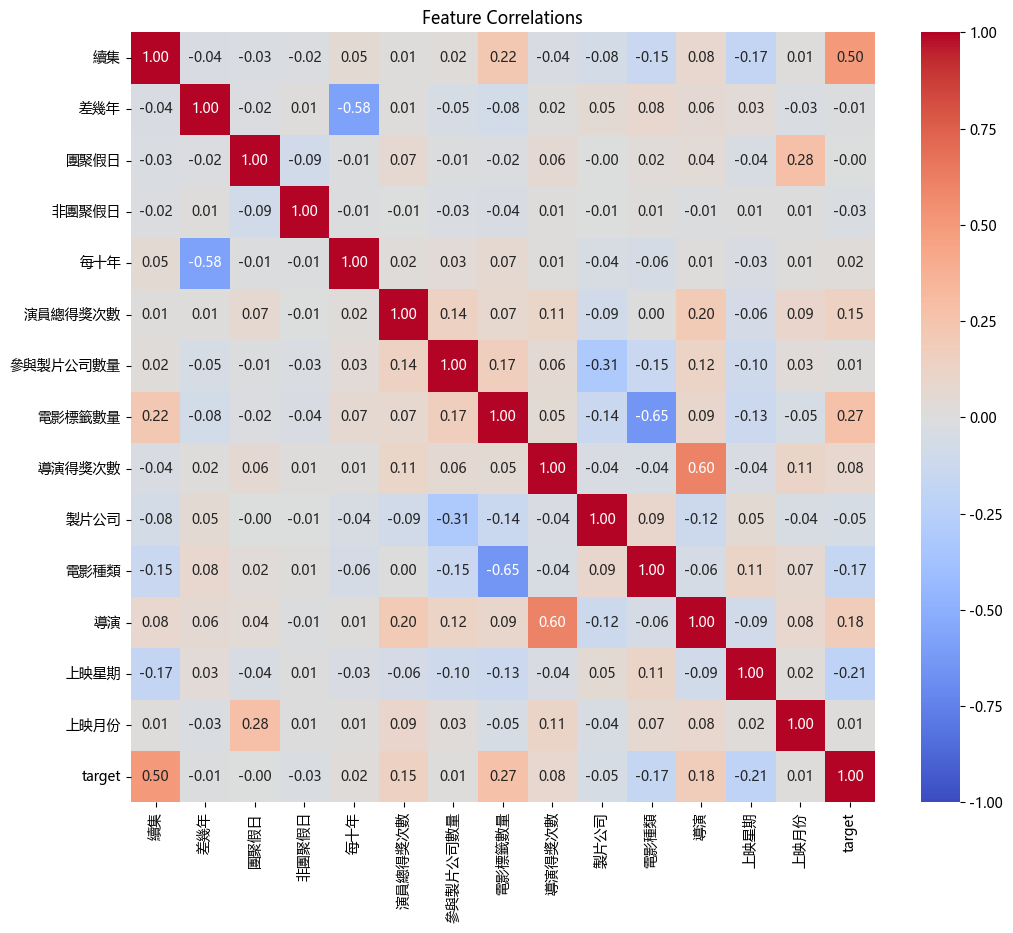

與目標變量的相關係數：
續集          0.498537
電影標籤數量      0.268872
上映星期        0.205474
導演          0.177268
電影種類        0.169574
演員總得獎次數     0.146470
導演得獎次數      0.082031
製片公司        0.047729
非團聚假日       0.025143
每十年         0.021164
上映月份        0.014932
差幾年         0.014320
參與製片公司數量    0.014065
團聚假日        0.000625
Name: target, dtype: float64

根據相關係數選擇的特徵：
Index(['續集', '電影標籤數量', '上映星期', '導演', '電影種類', '演員總得獎次數'], dtype='object')


Index(['續集', '電影標籤數量', '上映星期', '導演', '電影種類', '演員總得獎次數'], dtype='object')

In [101]:
def select_features_by_correlation(X, y, feature_names=None, threshold=0.1, plot_heatmap=True):
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(X.shape[1])]
    
    # 將 y 添加到 DataFrame 中
    X_with_target = X.copy()
    X_with_target['target'] = y
    X_with_target.columns = feature_names + ['target']

    # 計算相關係數
    correlations = X_with_target.corr()

    # 繪製熱力圖
    if plot_heatmap:
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
        plt.title("Feature Correlations")
        plt.show()

    # 計算與目標變量的相關係數並排序
    target_correlations = correlations['target'].drop('target', axis=0)
    target_correlations_sorted = target_correlations.abs().sort_values(ascending=False)

    print("與目標變量的相關係數：")
    print(target_correlations_sorted)

    # 挑選與目標變量相關係數絕對值大於某個閾值的特徵
    selected_features = target_correlations_sorted[target_correlations_sorted.abs() > threshold].index
    print("\n根據相關係數選擇的特徵：")
    print(selected_features)

    return selected_features



# 刪除與y相關性太高的預算及刪減部分相關性高的特徵欄位後再看一次
X = dfyear[['sequal','year_gap','reunion_holiday','non_reunion_holiday','decade','award_num','company_num','genres_num','directing_win_count','production_companies_freq','genres_freq','director_freq','release_weekday','release_month']]
feature_names=['續集','差幾年','團聚假日','非團聚假日','每十年','演員總得獎次數','參與製片公司數量','電影標籤數量','導演得獎次數','製片公司','電影種類','導演','上映星期','上映月份']
select_features_by_correlation(X, y, feature_names, threshold=0.1, plot_heatmap=True)


## 減少特徵後再次跑模型

In [20]:
# 減少特徵欄位
feature_names=['預算','續集','電影種類','製片公司','演員得獎次數','導演','上映星期']
X = dfyear[['budget','sequal','genres_freq','production_companies_freq','award_num','director_freq','release_weekday']]
y = dfyear['revenue']

LinearRegression R2 score: 0.6389513799461166
XGBoost R2 score: 0.6688243679354846
SVM R2 score: 0.6043465443083487
DecisionTree R2 score: 0.5367693752917891


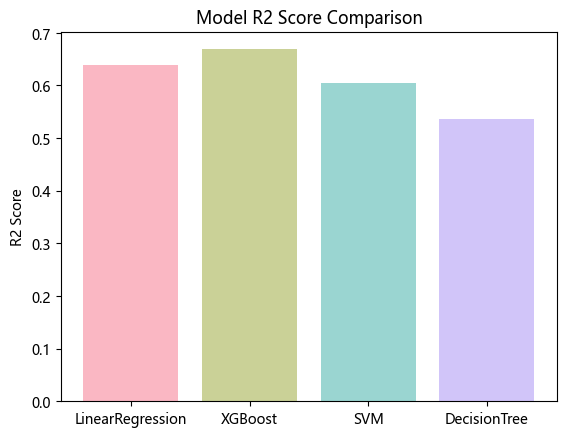

In [25]:
# 使用前面寫的方法
train_and_evaluate_models(X, y,random_state=36)

### 再度減少特徵 

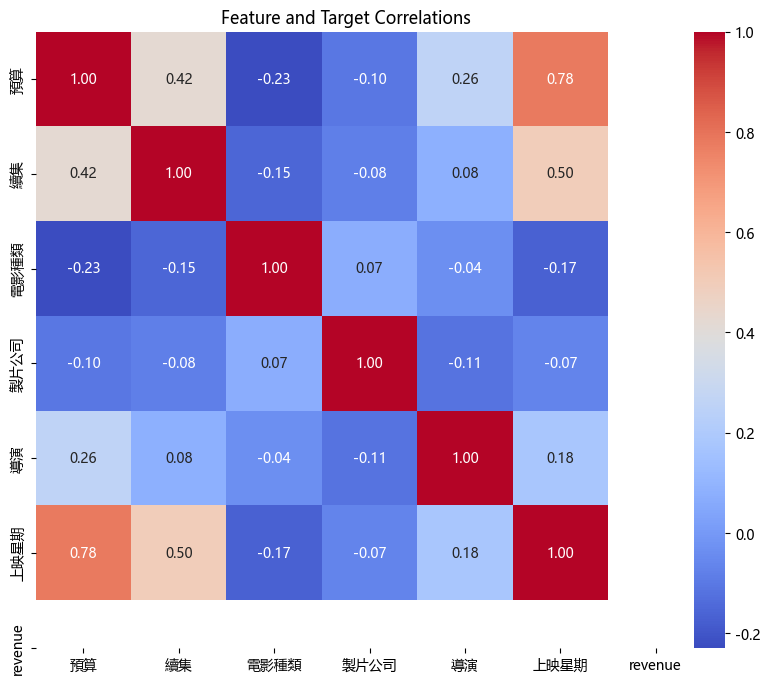

In [33]:
# 繪製相關係數熱力圖
# 這邊重複挑選特徵，互相比較驗證
feature_names=['演員總得獎次數','電影標籤數量','製片公司','電影種類','導演','上映星期','上映月份']
X = dfyear[['award_num','genres_num','production_companies_freq','genres_freq','director_freq','release_weekday','release_month',]]
y = dfyear['revenue_transfer']
select_features_by_correlation(X, y,feature_names=feature_names)

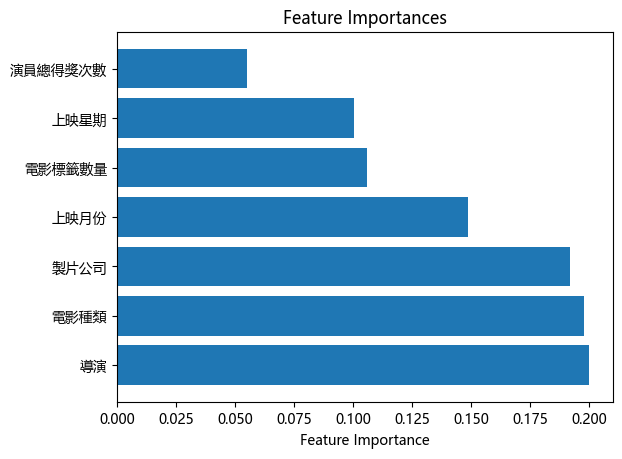

,award_num,genres_num,production_companies_freq,genres_freq,director_freq,release_weekday,release_month
3,0.0,2.0,0.000106,0.001063,0.000106,2.0,5.0
6,0.0,9.0,0.000106,0.000106,0.000213,1.0,1.0
8,0.0,1.0,0.000106,0.007444,0.000106,5.0,11.0
9,1.0,3.0,0.000106,0.000106,0.000213,6.0,4.0
10,0.0,2.0,0.000106,0.001063,0.000106,5.0,11.0
...,...,...,...,...,...,...,...
9399,0.0,2.0,0.000106,0.000425,0.000106,5.0,6.0
9400,0.0,2.0,0.000106,0.004147,0.000106,7.0,5.0
9401,0.0,2.0,0.000106,0.005317,0.000425,5.0,10.0
9402,0.0,3.0,0.000106,0.000106,0.000106,4.0,7.0


In [27]:
# 隨機森林篩選特徵
train_rf_and_get_importances_with_plot(X,y,problem_type="regression",feature_names=feature_names)

In [ ]:
# 上面動作重複，直到特徵選取結束
train_and_evaluate_models(X, y,random_state=36)

## 特徵選取結束 -> 調整超參數

In [25]:
# 最後的特徵
feature_names=['預算','續集','電影種類','製片公司','導演',]
X = dfyear[['budget','sequal','genres_freq','production_companies_freq','director_freq']]
y = dfyear['revenue']

# 將數據集拆分為訓練集、驗證集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)# 0.8、0.2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)# 0.8-> 0.6 0.2

In [14]:
# 定義繪製各別不同模型，各別參數R2表現
def plot_r2_scores_for_params(model_name, grid_search_results, xlabel):
    plt.figure()
    plt.plot(grid_search_results['param_' + xlabel], grid_search_results['mean_test_score'], 'o-', label=model_name)
    plt.xlabel(xlabel)
    plt.ylabel('R2 Score')
    plt.title(f'{model_name} R2 Score vs {xlabel}')
    plt.legend()
    plt.show()

In [15]:
# 繪製熱力圖，不同超參數下各模型R2分數
def plot_heatmap_for_params(model_name, grid_search_results, param_names):
    results_df = pd.DataFrame(grid_search_results)
    heatmap_data = results_df.pivot_table(
        values='mean_test_score',
        index=f'param_{param_names[0]}',
        columns=f'param_{param_names[1]}')
    sns.heatmap(heatmap_data, annot=True, fmt='.4g', cmap='viridis')
    plt.title(f'{model_name} R2 Heatmap')
    plt.show()


In [16]:
# 定義模型和其參數網格
models_and_param_grids = {
    'LinearRegression': {
        'model': LinearRegression(),
        'param_grid': {}  # LinearRegression has no hyperparameters to tune
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(),
        'param_grid': {
            'max_depth': [3, 5,],
            'n_estimators': [1000],
            'learning_rate': [0.01, 0.1,],
            'alpha': [0.5],
            'lambda': [0.5],
        }
    },
    'SVM': {
        'model': SVR(),
        'param_grid': {
            'kernel': ['linear'], # 'rbf'
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(),
        'param_grid': {
            'max_depth': [5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
}

LinearRegression R2 score: 0.6073636656449559
XGBoost R2 score: 0.6648785553934475


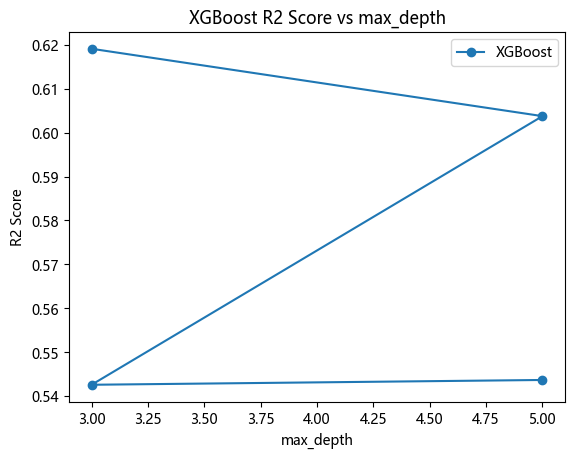

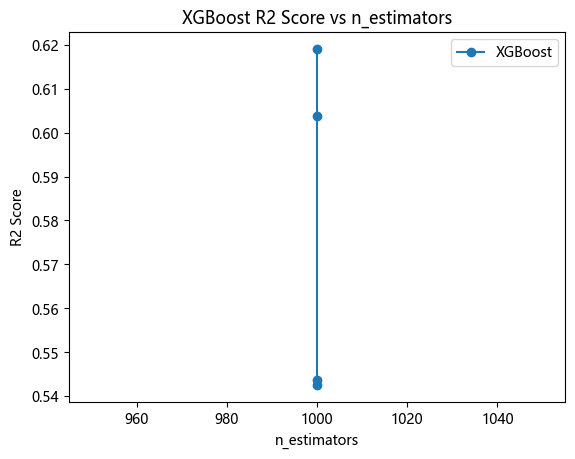

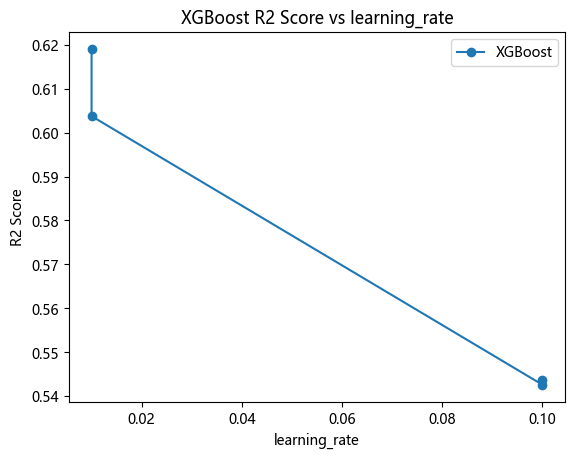

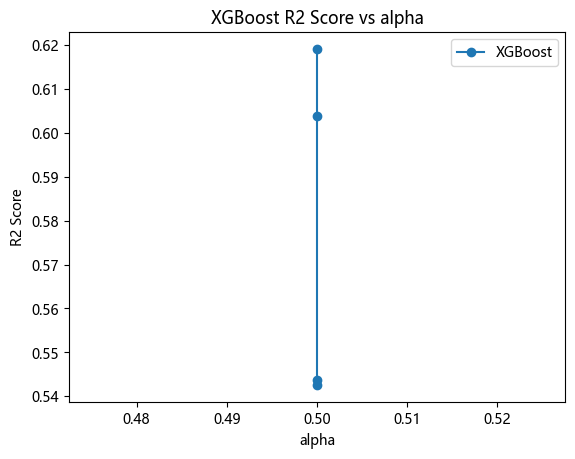

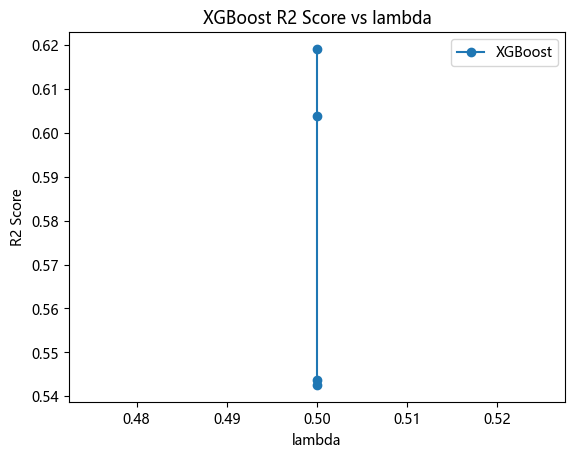

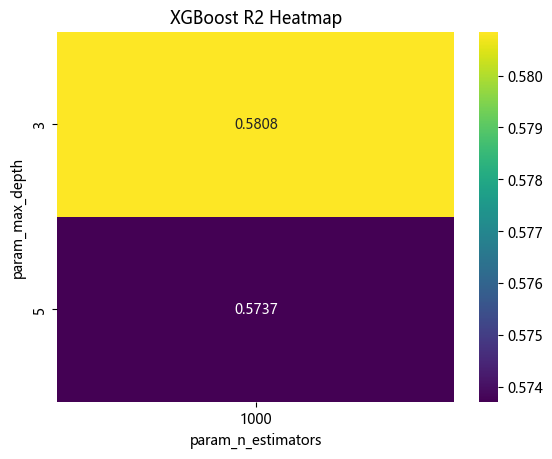

SVM R2 score: -0.14408430740100298


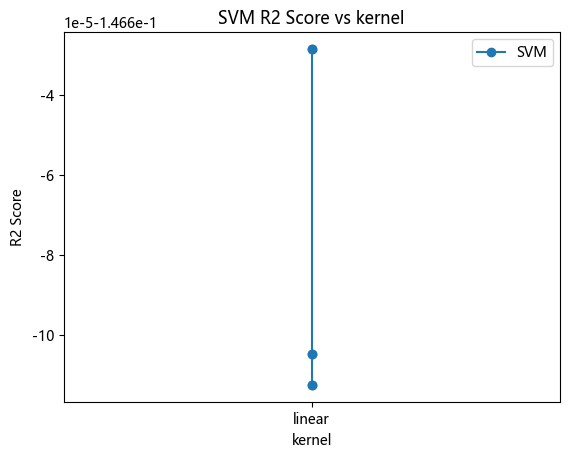

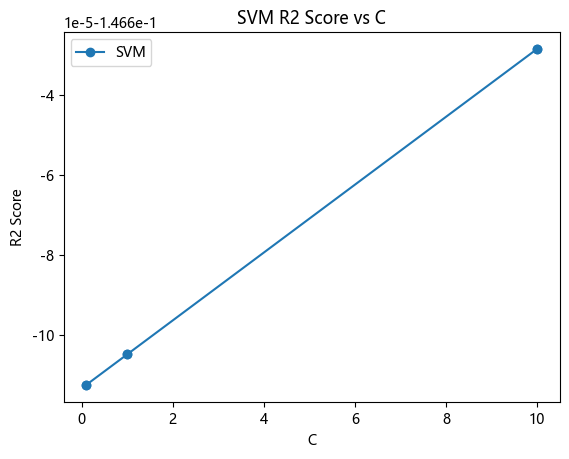

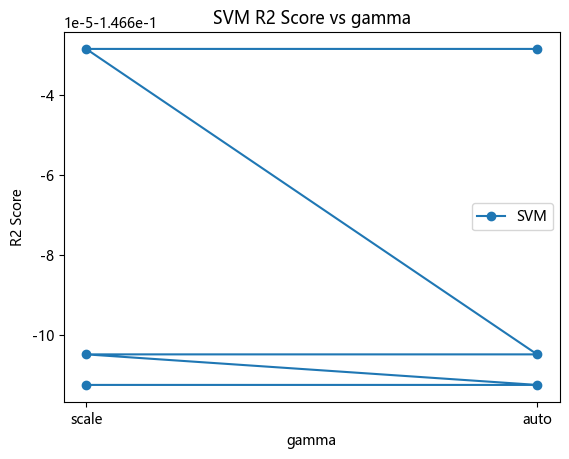

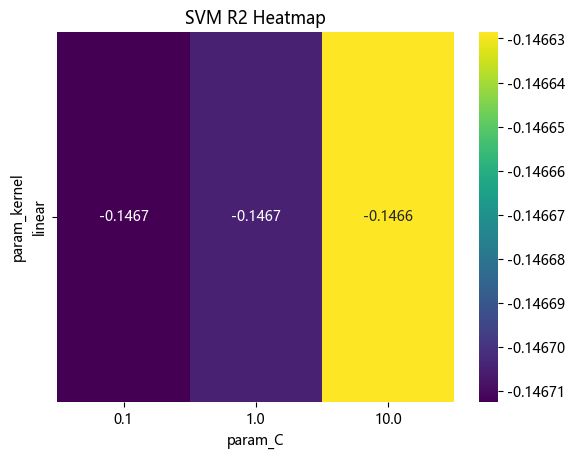

DecisionTree R2 score: 0.5947503834968132


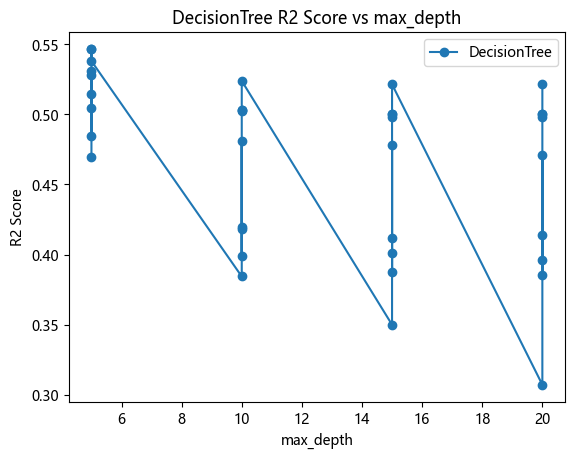

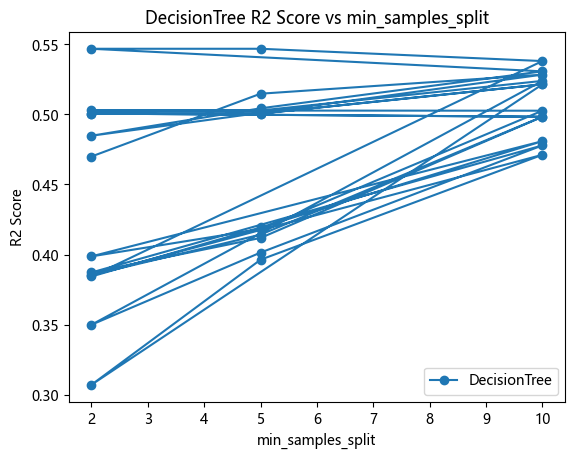

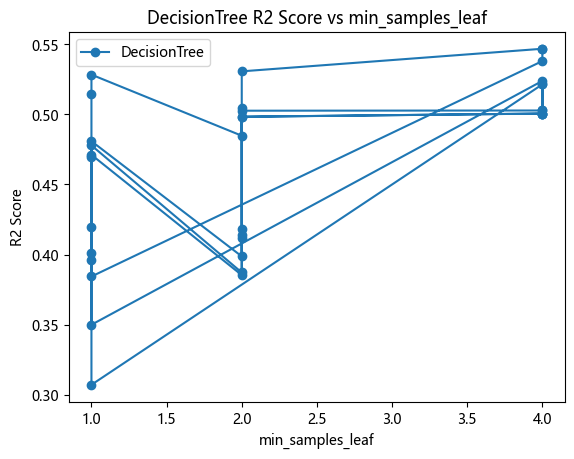

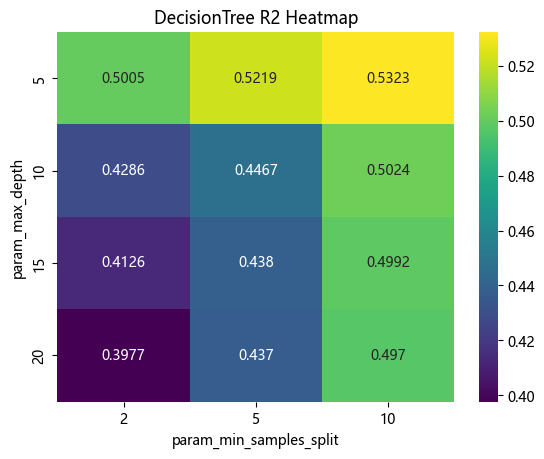

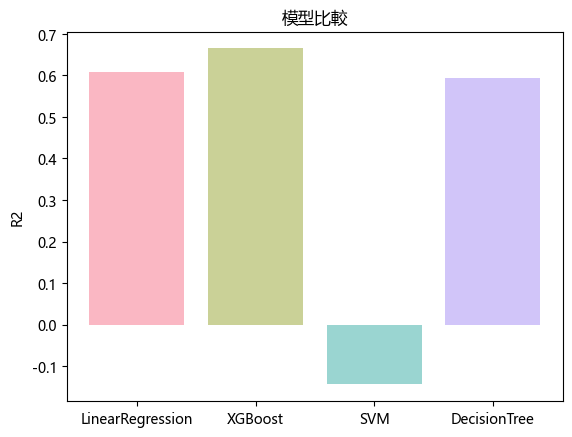

In [26]:
def GridSearchCV_models(X_train, X_val, y_train, y_val, random_state=48, scaler=StandardScaler(), y_scaler=StandardScaler ()):
    r2_scores = {}
    
    # 標準化 X
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    # # y視情況標準化
    # y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    # y_val = y_scaler.transform(y_val.values.reshape(-1, 1)).ravel()

    # 使用 GridSearchCV 訓練模型，獲取最佳參數組合，並繪製變化圖
    for model_name, model_and_param_grid in models_and_param_grids.items():
        grid_search = GridSearchCV(estimator=model_and_param_grid['model'],
                                   param_grid=model_and_param_grid['param_grid'],
                                   scoring='r2',
                                   n_jobs=-1,
                                   cv=5,
                                   return_train_score=True)
        grid_search.fit(X_train, y_train)
        grid_search_results = grid_search.cv_results_
        best_model = grid_search.best_estimator_
        preds = best_model.predict(X_val)
        r2_scores[model_name] = r2_score(y_val, preds)
        print(f'{model_name} R2 score: {r2_scores[model_name]}')

        # 繪製變化圖
        for param_name in model_and_param_grid['param_grid']:
            plot_r2_scores_for_params(model_name, grid_search_results, param_name)
        # 繪製熱力圖
        if len(model_and_param_grid['param_grid']) >= 2:
            param_names = list(model_and_param_grid['param_grid'].keys())
            plot_heatmap_for_params(model_name, grid_search_results, param_names[:2])
        
    # 繪製各模型最佳 R2 分數的條形圖
    colors = sns.color_palette("husl", len(models_and_param_grids))
    fig, ax = plt.subplots()
    model_names = list(r2_scores.keys())
    r2_values = list(r2_scores.values())
    y_pos = np.arange(len(model_names))
    ax.bar(y_pos, r2_values, align='center', alpha=0.5, color=colors)
    ax.set_xticks(y_pos)
    ax.set_xticklabels(model_names)
    ax.set_ylabel('R2')
    ax.set_title('模型比較')
    plt.show()

    return r2_scores

r2_scores = GridSearchCV_models(X_train, X_val, y_train, y_val, random_state=42)


In [27]:
best_model_name = max(r2_scores, key=r2_scores.get)
scaler = StandardScaler()
# 使用驗證集選擇最佳模型
best_model_name = max(r2_scores, key=r2_scores.get)
best_model = models_and_param_grids[best_model_name]['model']

# 使用最佳模型在整個訓練數據集上進行訓練（訓練集和驗證集）
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

X_train_val = scaler.fit_transform(X_train_val)  # 標準化整個訓練數據集
best_model.fit(X_train_val, y_train_val)

# 使用測試集進行最終評估
X_test = scaler.transform(X_test)  # 標準化測試集
test_preds = best_model.predict(X_test)
test_r2_score = r2_score(y_test, test_preds)

print(f"{best_model_name} 在測試集上的 R2 分數：{test_r2_score}")


XGBoost 在測試集上的 R2 分數：0.588775167557174


d:\Users\hanklee\anaconda3\envs\sst\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## 將最終訓練的模型存檔 供Flask使用

In [28]:
# 存成CSV形式
def save_freq_dict(df, feature_name):
    freq_dict = df.set_index(feature_name)[f"{feature_name}_freq"].to_dict()
    freq_df = pd.DataFrame(freq_dict.items(), columns=[feature_name, 'freq'])
    freq_df.to_csv(f"{feature_name}_freq_mapping.csv", index=False)

# 預計有哪些欄位需要對應存檔
save_freq_dict(df, "genres")
save_freq_dict(df, "production_companies")
save_freq_dict(df, "director")


In [29]:
# 將頻率編碼對應的欄位數字存成字典pkl檔
def save_freq_dict(df, feature_name):
    freq_dict = df.set_index(feature_name)[f"{feature_name}_freq"].to_dict()
    with open(f"{feature_name}_freq_mapping.pkl", "wb") as file:
        pickle.dump(freq_dict, file)

# 預計有哪些欄位需要對應存檔
save_freq_dict(df, "genres")
save_freq_dict(df, "production_companies")
save_freq_dict(df, "director")


In [30]:
# 模型存檔
with open(f"{best_model_name}_best_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

# 標準化數據存檔
with open(f"{best_model_name}_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

## 模型(暫未使用)

### Quantile regression

In [ ]:
X = dfyear[['budget_transfer','sequal','genres_freq','production_companies_freq','award_num','director_freq','release_weekday']]
y = dfyear['revenue_transfer']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=48)

# 將資料分成三份 調整參數
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 標準化
# scaler = StandardScaler()
# # 對訓練集進行標準化
# X_train = scaler.fit_transform(X_train)
# # 對驗證集進行標準化
# X_val = scaler.transform(X_val)
# # 對測試集進行標準化
# X_test = scaler.transform(X_test)
# y_scaler = StandardScaler()  # Create a separate scaler for y
# # 對Y也進行標準化
# y_train = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1)).ravel()
# y_val = y_scaler.transform(np.array(y_val).reshape(-1, 1)).ravel()
# y_test = y_scaler.transform(np.array(y_test).reshape(-1, 1)).ravel()

c:\Users\student\anaconda3\envs\ML_env\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\student\anaconda3\envs\ML_env\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


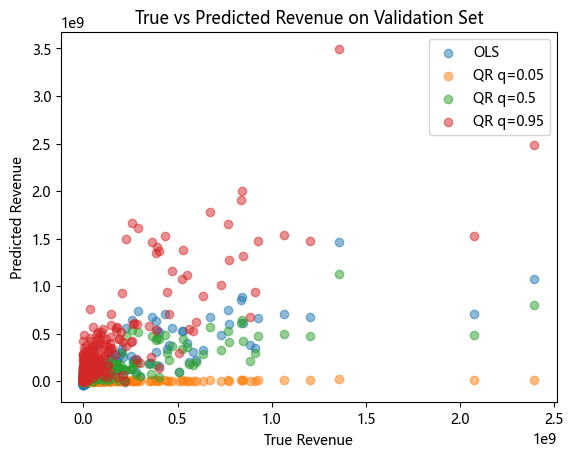

OLS R-squared: 0.6764482440250601
OLS Mean Squared Error: 2.3214599366323324e+16
OLS Mean Absolute Error: 73100240.48780216


In [ ]:
# 添加常數項到數據集
X_train = sm.add_constant(X_train) # 在訓練集中添加常數項
X_val = sm.add_constant(X_val) # 在驗證集中添加常數項
X_test = sm.add_constant(X_test) # 在測試集中添加常數項

# 使用statsmodels擬合OLS線性回歸
ols_model = sm.OLS(y_train, X_train).fit() # 使用OLS擬合線性回歸模型

# 定義分位數
quantiles = [0.05, 0.5, 0.95] # 定義分位數為0.05、0.5和0.95

# 擬合Quantile Regression模型
qr_models = [] # 初始化Quantile Regression模型列表
for q in quantiles:
    qr_model = sm.QuantReg(y_train, X_train).fit(q=q) # 使用Quantile Regression擬合模型
    qr_models.append(qr_model) # 將擬合好的Quantile Regression模型添加到列表中

# 在驗證集上計算預測值
ols_y_pred = ols_model.predict(X_val) # 計算OLS模型在驗證集上的預測值
qr_y_preds = [] # 初始化Quantile Regression預測值列表
for qr_model in qr_models:
    qr_y_pred = qr_model.predict(X_val) # 計算Quantile Regression模型在驗證集上的預測值
    qr_y_preds.append(qr_y_pred) # 將預測值添加到列表中

# 繪製預測值與真實值的散點圖
plt.scatter(y_val, ols_y_pred, label="OLS", alpha=0.5)

for q, qr_y_pred in zip(quantiles, qr_y_preds):
    plt.scatter(y_val, qr_y_pred, label=f"QR q={q}", alpha=0.5)

plt.xlabel("True Revenue") # 設置x軸標籤為"True Revenue"
plt.ylabel("Predicted Revenue") # 設置y軸標籤為"Predicted Revenue"
plt.legend() # 顯示圖例
plt.title("True vs Predicted Revenue on Validation Set") # 設置圖表標題為"驗證集上真實值與預測值的比較"
plt.show()

# 計算和顯示評估指標
ols_r2 = r2_score(y_val, ols_y_pred)
ols_mse = mean_squared_error(y_val, ols_y_pred)
ols_mae = mean_absolute_error(y_val, ols_y_pred)

print("OLS R-squared:", ols_r2)
print("OLS Mean Squared Error:", ols_mse)
print("OLS Mean Absolute Error:", ols_mae)

for q, qr_y_pred in zip(quantiles


### LASSO

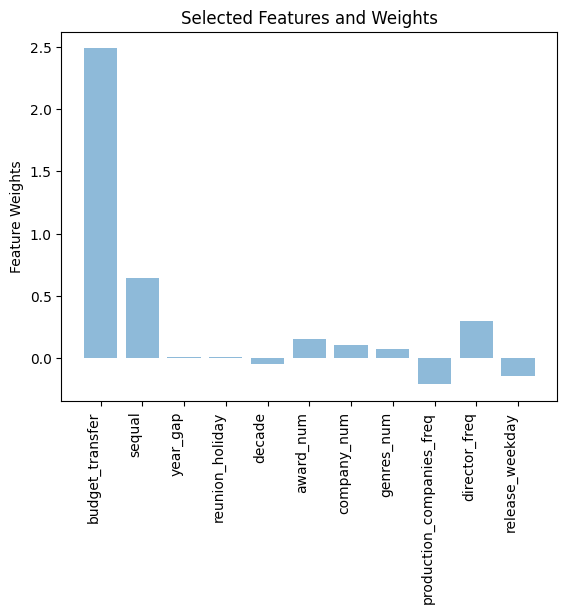

(Index(['budget_transfer', 'sequal', 'year_gap', 'reunion_holiday', 'decade',
        'award_num', 'company_num', 'genres_num', 'production_companies_freq',
        'director_freq', 'release_weekday'],
       dtype='object'),
 array([ 2.48555526,  0.64669332,  0.00727589,  0.0073102 , -0.04578384,
         0.15253894,  0.11016982,  0.07621277, -0.20981391,  0.29887646,
        -0.13779972]))

In [ ]:
# 用來挑選特徵的模型之一
def select_features_with_lasso_and_visualize(X, y, alpha=0.1):
    scaler = StandardScaler()  # 初始化 StandardScaler 物件
    X_scaled = scaler.fit_transform(X)  # 對特徵進行標準化

    lasso = Lasso(alpha=alpha)  # 初始化 Lasso 物件
    lasso.fit(X_scaled, y)  # 使用 Lasso 進行特徵選擇

    nonzero_indices = np.nonzero(lasso.coef_)[0]  # 獲取選定的非零特徵索引
    selected_features = X.columns[nonzero_indices]  # 獲取選定的特徵名稱
    feature_weights = lasso.coef_[nonzero_indices]  # 獲取選定的特徵權重

    # 可視化選定的特徵及其權重
    fig, ax = plt.subplots()
    y_pos = np.arange(len(selected_features))
    ax.bar(y_pos, feature_weights, align='center', alpha=0.5)
    ax.set_xticks(y_pos)
    ax.set_xticklabels(selected_features, rotation=90, ha='right')
    ax.set_ylabel('特徵權重')  # 設定 y 軸標籤為 "Feature Weights"
    ax.set_title('選定的特徵及其權重')  # 設定圖表標題為 "選定的特徵及其權重"
    plt.show()

    return selected_features, feature_weights


Best R2 score: 0.5825599608428458


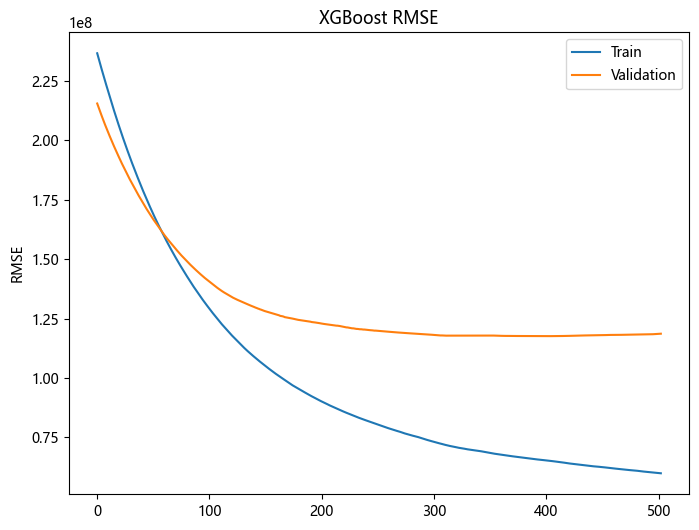

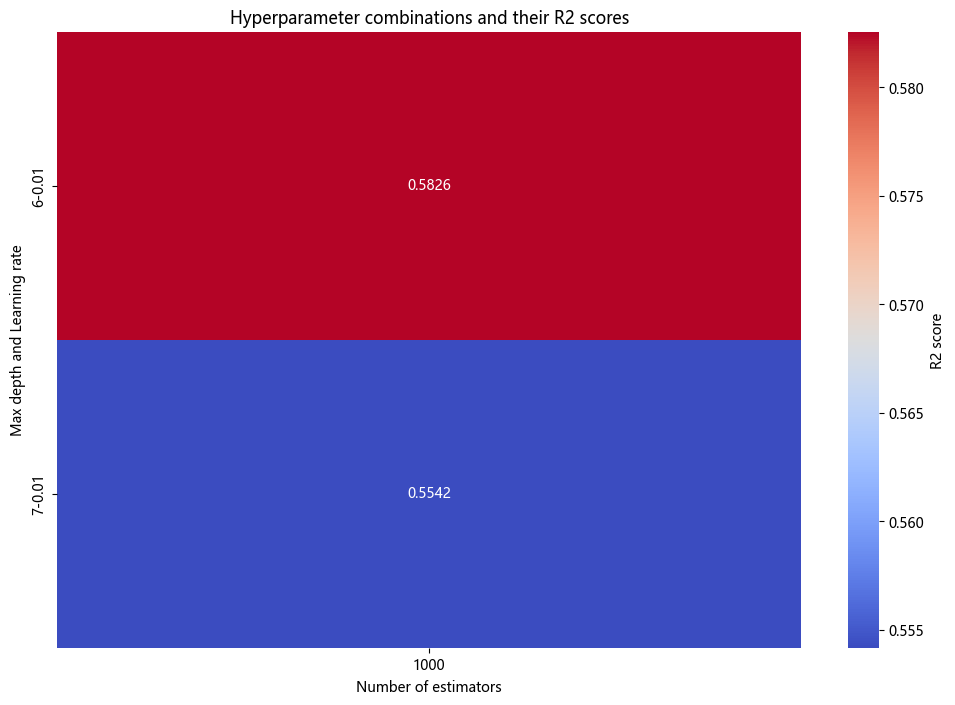

In [ ]:
def xgb_gridsearch_train(X_train, y_train, X_val, y_val, feature_names=None, param_grid=None, eval_metric='mae', plot_learning_curve=True, plot_feature_importance=True):

    if not param_grid:
        param_grid = {
            'max_depth': [6,7],
            'n_estimators': [1000],
            'learning_rate': [0.01],
            'random_state': [42],
            'eval_metric': [eval_metric],
            'objective': ['reg:squarederror'],
            'tree_method':[ 'auto'],  # 使用GPU
            'gpu_id': [0],                # 指定GPU設備ID

        }

    xgb_model = xgb.XGBRegressor()
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    xgb_best_model = xgb.XGBRegressor(**best_params, early_stopping_rounds=100)
    xgb_best_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)
    best_r2 = grid_search.best_score_
    print(f'Best R2 score: {best_r2}')
    
    if plot_learning_curve:
        plt.figure(figsize=(8, 6))
        train_results = xgb_best_model.evals_result()
        eval_metric_key = list(train_results['validation_0'].keys())[0]  # Get the first key in the dictionary
        epochs = len(train_results['validation_0'][eval_metric_key])
        x_axis = range(0, epochs)
        plt.plot(x_axis, train_results['validation_0'][eval_metric_key], label='Train')
        plt.plot(x_axis, train_results['validation_1'][eval_metric_key], label='Validation')  # Change the label to "Validation"
        plt.legend()
        plt.ylabel(eval_metric.upper())
        plt.title(f'XGBoost {eval_metric.upper()}')
        plt.show()


    if feature_names is not None and plot_feature_importance:
        X2 = sm.add_constant(X_train)
        ols_model = sm.OLS(y_train, X2)
        ols_results = ols_model.fit()
        p_values = ols_results.pvalues[1:]
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'P_value': p_values})
        feature_importance_df_sorted = feature_importance_df.sort_values('P_value')

        plt.figure(figsize=(10, 5))
        sns.barplot(x='P_value', y='Feature', data=feature_importance_df_sorted)
        plt.xlabel('P-value')
        plt.ylabel('Features')
        plt.title('Feature Importance based on P-value')
        plt.show()
    cv_results_df = pd.DataFrame(grid_search.cv_results_)

    # Extract the parameters and mean_test_score columns
    params_scores_df = cv_results_df.loc[:, ['params', 'mean_test_score']]

    # Convert the params column into individual columns for each hyperparameter
    params_df = params_scores_df['params'].apply(pd.Series)

    # Concatenate the parameters columns and the mean_test_score column
    params_scores_df = pd.concat([params_df, params_scores_df['mean_test_score']], axis=1)

    # Reshape the DataFrame to have one hyperparameter per axis and the mean_test_score as values
    params_scores_pivot = params_scores_df.pivot_table(index=['max_depth', 'learning_rate'], columns=['n_estimators'], values='mean_test_score')

    # Plot a heatmap of the hyperparameter combinations and their corresponding mean_test_score
    plt.figure(figsize=(12, 8))
    sns.heatmap(params_scores_pivot, annot=True, fmt='.4f', cmap='coolwarm', cbar_kws={'label': 'R2 score'})
    plt.title('Hyperparameter combinations and their R2 scores')
    plt.xlabel('Number of estimators')
    plt.ylabel('Max depth and Learning rate')
    plt.show()

    if feature_names is not None:
        return xgb_best_model, feature_importance_df_sorted, best_r2
    else:
        return xgb_best_model, None, best_r2





xgb_best_model, feature_importance_df_sorted, best_r2=xgb_gridsearch_train(X_train, y_train, X_val, y_val,eval_metric='rmse' )


### XGBOOST

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=48)

# 將資料分成三份 調整參數
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 標準化
# scaler = StandardScaler()
# # 對訓練集進行標準化
# X_train = scaler.fit_transform(X_train)
# # 對驗證集進行標準化
# X_val = scaler.transform(X_val)
# # 對測試集進行標準化
# X_test = scaler.transform(X_test)
y_scaler = StandardScaler()  # Create a separate scaler for y
# # 對Y也進行標準化
# y_train = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1)).ravel()
# y_val = y_scaler.transform(np.array(y_val).reshape(-1, 1)).ravel()
# y_test = y_scaler.transform(np.array(y_test).reshape(-1, 1)).ravel()


Best R2 score: 0.6066321434105781


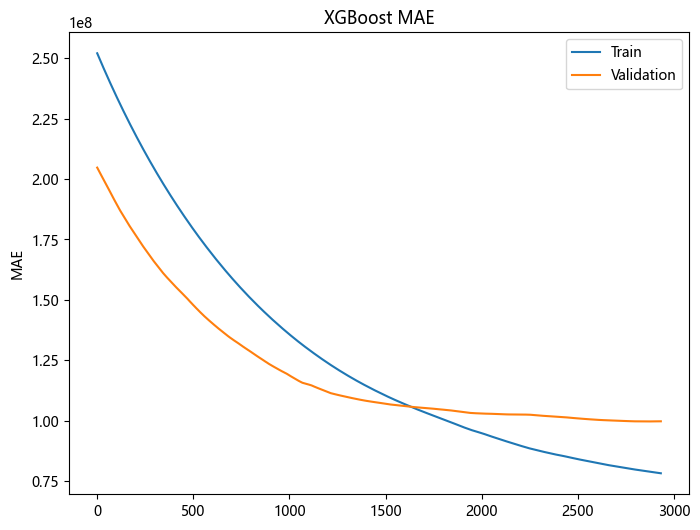

ValueError: array length 14 does not match index length 5

In [ ]:
# 調整超參數，訓練最終模型
param_grid = {
            'max_depth': [6,7,8],
            'n_estimators': [2000],
            'learning_rate': [0.001, 0.01, 0.1],
            'random_state': [1],

            'objective': ['reg:squarederror'],
            'tree_method':[ 'auto'],  # 使用GPU
            'gpu_id': [0]
        }
xgb_best_model, feature_importance_df_sorted, best_r2=xgb_gridsearch_train(X_train, y_train, X_val, y_val, feature_names=feature_names,eval_metric='mae',param_grid=param_grid )

In [ ]:
# 使用最佳模型在測試集上進行預測
y_pred_test = xgb_best_model.predict(X_test)

# 反標準化預測值
# y_pred_test_unscaled = y_scaler.inverse_transform(y_pred_test)

# # 反標準化真實值
# y_test_unscaled = y_scaler.inverse_transform(y_test)

# 計算 R2 分數
test_r2 = r2_score(y_test, y_pred_test)
print(f"Test R2 score: {test_r2}")

# 計算其他性能指標，如均方誤差 (MSE) 和均方根誤差 (RMSE)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
